In [1]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

import sys

In [2]:
@njit
def adim_free_dyadic(vec_r1, vec_r2, k0):
    a0 = 60. + 1j*0. #space cutoff in nm
    r = k0*( vec_r1 - vec_r2 ) + 1j*0.
    r0 = np.sqrt(np.abs(np.dot(r,r)) ) + 1j*0.
    
    G = np.zeros( shape=(3,3), dtype=np.complex_ )

    r_k_r = ( np.outer(r,r) ) + 1j*0.
    if np.abs(r0) > .00001:

        G = np.exp( 1j*r0 )/(4*np.pi) * ( (1./r0 + 1./r0**2. - 1./r0**3.)*np.eye(3) + (3./r0**3. - 3.*1j/r0**2. - 1./r0)*r_k_r/r0**2.  ) * ( 1. - np.exp(-(np.abs(r0/k0/a0))**4.) )
    
    return G
@njit
def adim_half_space_dyadic(vec_r1, vec_r2, k0_ref, z0, img_active):
    img_A = 0
    if img_active == 1:
        img_A = 1
    
    reflectance = 1.
    
    k0 = k0_ref + 1j*k0_ref*.0
        
    r = k0*( vec_r1 - vec_r2 ) + 1j*0.
    r0 = np.sqrt(np.abs(np.dot(r,r)) ) + 1j*0.
    
    Mrinv = np.diag( np.array([1.+1j*0., 1.+1j*0., -1.+1j*0.]) )
    MZ = np.diag( np.array([0.+1j*0., 0.+1j*0., 1.+1j*0.]) )
    
    plane_pos = np.array([0.+1j*0., 0.+1j*0., z0+1j*0.])
    rI = k0*(vec_r1 - ( Mrinv @ (vec_r2+1j*0.) + 2.*plane_pos ) ) + 1j*0.
    rI0 = np.sqrt(np.abs(np.dot(rI,rI)) ) + 1j*0.
    
    r_k_r = ( np.outer(r,r) ) + 1j*0.
    rI_k_rI = ( np.outer(rI,rI) ) + 1j*0.
    
    G = np.zeros( shape=(3,3), dtype=np.complex_ )
    G0 = np.zeros( shape=(3,3), dtype=np.complex_ )
    GI = np.zeros( shape=(3,3), dtype=np.complex_ )
    if np.abs(r0) > .0001:
        Mn0 = - np.exp( 1j*r0 )/(4*np.pi) * ( np.eye(3)/r0**3. - 3.*r_k_r/r0**5. ) #* ( 1. - np.exp(-(np.abs(r0/k0/a0))**4.) )
        Mf0 = np.exp( 1j*r0 )/(4*np.pi)*( np.eye(3)*( 1./r0 + 1j/r0**2.) - r_k_r/r0**2.*( 1./r0 + 3*1j/r0**2.) )
        G0 = Mf0 + Mn0
    
    if np.abs(rI0) > .000001:   
        MnI = - np.exp( 1j*rI0 )/(4*np.pi) * ( np.eye(3)/rI0**3. - 3.*rI_k_rI/rI0**5. )
        MfI = np.exp( 1j*rI0 )/(4*np.pi)*( np.eye(3)*( 1./rI0 + 1j/rI0**2.) - rI_k_rI/rI0**2.*( 1./rI0 + 3*1j/rI0**2.) )
        GI = MfI + MnI #- 2.*MZ*np.exp( 1j*rI0 )/(4*np.pi)*( 1./rI0)
    G = G0 - img_A*reflectance * (GI @ Mrinv )
    
    return G

@njit
def system_dyadic_field_amplitude( R, D, k0, N_TLS, xvec, yvec, zvec, z0, img_active ):    
    arr_Ex = np.zeros(shape=(xvec.size*yvec.size*zvec.size, N_TLS), dtype=np.complex_)
    arr_Ey = np.zeros(shape=(xvec.size*yvec.size*zvec.size, N_TLS), dtype=np.complex_)
    arr_Ez = np.zeros(shape=(xvec.size*yvec.size*zvec.size, N_TLS), dtype=np.complex_)
    
    count = 0
    for nx in range(xvec.size):
        for ny in range(yvec.size):
            for nz in range(zvec.size):
                for n in range(N_TLS):
                    G = adim_half_space_dyadic( np.array([xvec[nx], yvec[ny], zvec[nz]]), R[n], k0, z0, img_active )
                    E = (G + 1j*0.) @ (D[n]+1j*0.)
                    arr_Ex[count][n] = E[0]
                    arr_Ey[count][n] = E[1]
                    arr_Ez[count][n] = E[2]
                count += 1

    return arr_Ex, arr_Ey, arr_Ez

@njit
def polar_system_dyadic_field_amplitude( R, D, k0, N_TLS, theta, phi, dist, z0, img_active ):    
    arr_Ex = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    arr_Ey = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    arr_Ez = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    
    count = 0
    for n2 in range(phi.size):
        for n1 in range(theta.size):
            for n in range(N_TLS):
                x = dist * np.sin(phi[n2]) * np.cos(theta[n1])
                y = dist * np.sin(phi[n2]) * np.sin(theta[n1])
                z = dist * np.cos(phi[n2])
                G = adim_half_space_dyadic( np.array([x, y, z]), R[n], k0, z0, img_active )
                E = (G + 1j*0.) @ (D[n]+1j*0.)
                arr_Ex[count][n] = E[0]
                arr_Ey[count][n] = E[1]
                arr_Ez[count][n] = E[2]
            count += 1

    return arr_Ex, arr_Ey, arr_Ez

@njit
def polar_system_dyadic_field_amplitude( R, D, k0, N_TLS, theta, phi, dist, z0, img_active ):    
    arr_Ex = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    arr_Ey = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    arr_Ez = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    
    count = 0
    for n2 in range(phi.size):
        for n1 in range(theta.size):
            for n in range(N_TLS):
                x = dist * np.sin(phi[n2]) * np.cos(theta[n1])
                y = dist * np.sin(phi[n2]) * np.sin(theta[n1])
                z = dist * np.cos(phi[n2])
                G = adim_half_space_dyadic( np.array([x, y, z]), R[n], k0, z0, img_active )
                E = (G + 1j*0.) @ (D[n]+1j*0.)
                arr_Ex[count][n] = E[0]
                arr_Ey[count][n] = E[1]
                arr_Ez[count][n] = E[2]
            count += 1

    return arr_Ex, arr_Ey, arr_Ez

@njit
def polar_matrix_system_dyadic_field_amplitude( R, D, k0, N_TLS, theta, phi, dist, z0, img_active ):    
    arr_Ex = np.zeros(shape=(theta.size, phi.size, N_TLS), dtype=np.complex_)
    arr_Ey = np.zeros(shape=(theta.size, phi.size, N_TLS), dtype=np.complex_)
    arr_Ez = np.zeros(shape=(theta.size, phi.size, N_TLS), dtype=np.complex_)
    
    for n2 in range(phi.size):
        for n1 in range(theta.size):
            for n in range(N_TLS):
                x = dist * np.sin(phi[n2]) * np.cos(theta[n1])
                y = dist * np.sin(phi[n2]) * np.sin(theta[n1])
                z = dist * np.cos(phi[n2])
                G = adim_half_space_dyadic( np.array([x, y, z]), R[n], k0, z0, img_active )
                E = (G + 1j*0.) @ (D[n]+1j*0.)
                arr_Ex[n1][n2][n] = E[0]
                arr_Ey[n1][n2][n] = E[1]
                arr_Ez[n1][n2][n] = E[2]

    return arr_Ex, arr_Ey, arr_Ez

@njit
def interaction_matrix(R, D, k0, N, z0, img_active):
    K = np.zeros( shape=(N,N), dtype=np.complex_  )
    for n1 in range(N):
        for n2 in range(N):
            G = adim_half_space_dyadic(R[n1], R[n2], k0, z0, img_active)
            K[n1][n2] = np.vdot( (D[n1]+1j*0.) , ( (G + 1j*0.) @ (D[n2] + 1j*0.) ) )

    return K


In [3]:
def spherical_distance(theta1, phi1, theta2, phi2):
    """
    Compute the great-circle distance between two points on the sphere.
    
    Parameters:
    - theta1, phi1: coordinates of the first point in radians.
    - theta2, phi2: coordinates of the second point in radians.
    
    Returns:
    - distance: the great-circle distance.
    """
    delta_theta = theta2 - theta1
    delta_phi = phi2 - phi1
    a = np.sin(delta_theta / 2)**2 + np.cos(theta1) * np.cos(theta2) * np.sin(delta_phi / 2)**2
    return 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def create_spherical_kernel(size, theta0, phi0):
    """
    Create a spherical averaging kernel of a given size around a central point.
    
    Parameters:
    - size: int, the size of the kernel in each dimension.
    - theta0, phi0: coordinates of the central point in radians.
    
    Returns:
    - kernel: 2D numpy array, the spherical averaging kernel.
    """
    kernel = np.zeros((size, size))
    center = size // 2
    theta_range = np.linspace(theta0 - np.pi/size, theta0 + np.pi/size, size)
    phi_range = np.linspace(phi0 - 2*np.pi/size, phi0 + 2*np.pi/size, size)
    
    for i in range(size):
        for j in range(size):
            kernel[i, j] = spherical_distance(theta0, phi0, theta_range[i], phi_range[j])
    
    kernel = np.exp(-kernel**2 / (2 * (np.pi/size)**2))  # Gaussian-like weight based on distance
    kernel /= kernel.sum()  # Normalize the kernel
    return kernel

def create_averaging_kernel(size):
    """
    Create a normalized averaging kernel of a given size.
    
    Parameters:
    - size: int, the size of the kernel in each dimension.
    
    Returns:
    - kernel: 2D numpy array, the averaging kernel.
    """
    kernel = np.ones((size, size))
    kernel /= kernel.sum()
    return kernel

@njit
def solid_angle_averaging(I, Mprovv, theta, phi, limit_angle):
    #avgI = I.copy()*0
    for n2 in range(phi.size):
        for n1 in range(theta.size):
            theta0 = theta[n1]
            phi0 = phi[n2]
            X0 = np.array( [np.cos(theta0)*np.sin(phi0), np.sin(theta0)*np.sin(phi0), np.cos(phi0) ] )
            count = 0
            total_weight = 0
            for nph in range(phi.size):
                for nth in range(theta.size):
                    theta_n = theta[nth]
                    phi_n = phi[nph]
                    Xtp = np.array( [np.cos(theta_n)*np.sin(phi_n), np.sin(theta_n)*np.sin(phi_n), np.cos(phi_n) ] )
                    projection = np.dot(X0, Xtp)
                    if projection >= np.cos(limit_angle):
                        weight = np.sin(phi_n)
                        Mprovv[n1,n2,:,:] += I[nth,nph,:,:]*weight
                        total_weight += weight
                        count += 1
            if total_weight > 0:
                Mprovv[n1,n2,:,:] = Mprovv[n1,n2,:,:]/total_weight
            #if count > 0:
            #    Mprovv[n1,n2,:,:] = Mprovv[n1,n2,:,:]/count
    
    return Mprovv


def avg_solid_angle(I, Nn, theta, phi, kernel_size):
    # Define the averaging kernel (e.g., 3x3)
    #kernel_size = 4  # Size of the kernel
    #kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)

    # Initialize the output tensor M_averaged with the same shape as M
    I_averaged = np.zeros_like(I)

    # Apply convolution along the first two dimensions for each (n, m) slice
    for n in range(Nn):
        for m in range(Nn):
            #kernel = create_spherical_kernel(kernel_size, phi[m], theta[n])
            kernel = create_averaging_kernel(kernel_size)
            I_averaged[:, :, n, m] = scipy.ndimage.convolve(I[:, :, n, m], kernel, mode='reflect')

    return I_averaged

In [4]:
def uniform_random_lattice(volume_bounds, L, N, max_attempts=10000):
    """
    Generate N points randomly within a specified volume ensuring minimum distance L between points.

    :param volume_bounds: A tuple of 6 elements defining the bounds (x_min, x_max, y_min, y_max, z_min, z_max).
    :param L: Minimum distance between points.
    :param N: Number of points to generate.
    :param max_attempts: Maximum number of attempts to generate each valid point.
    :return: A numpy array of points.
    """
    x_min, x_max, y_min, y_max, z_min, z_max = volume_bounds
    points = []

    def is_valid(point):
        """Check if the point is at least distance L away from all existing points."""
        for p in points:
            if np.linalg.norm(point - p) < L:
                return False
        return True

    while len(points) < N:
        attempts = 0
        while attempts < max_attempts:
            point = np.array([
                np.random.uniform(x_min, x_max),
                np.random.uniform(y_min, y_max),
                np.random.uniform(z_min, z_max)
            ])

            if is_valid(point):
                points.append(point)
                break
            else:
                attempts += 1

        if attempts >= max_attempts:
            print(f"Reached max attempts for a point. Generated {len(points)} points out of {N} requested.")
            break
    
    R = np.array(points)  
    N_TLS = R.shape[0]
    
    Rc = np.sum(R, axis=0)/N_TLS
    R[:,0] -= Rc[0]
    R[:,1] -= Rc[1]
    R[:,2] -= Rc[2]
    
    return R, N_TLS
def ordered_chain(L, N):
    R = np.zeros(shape=(N,3))
    for n in range(N):
        R[n][2] = n*L
    
    Rc = np.sum(R, axis=0)/N
    R[:,0] -= Rc[0]
    R[:,1] -= Rc[1]
    R[:,2] -= Rc[2]
    return R 

def triang_triangular_lattice( L, Nx, Ny ):
    N = Nx*Ny
    R = np.zeros(shape=(N,3))
    n=0
    for y in range(Ny):
        if y < Nx:
            for x in range(Nx-y):
                if y%2==0:
                    R[n][0] = x + .5*(y)
                    R[n][1] = y*(np.sqrt(3.)/2.)
                else:
                    R[n][0] = x + .5 + .5*(y-1)
                    R[n][1] = y*(np.sqrt(3.)/2.)
                n += 1
    M = n
    Rc = np.sum(R, axis=0)/M
    R[:,0] -= Rc[0]
    R[:,1] -= Rc[1]
    R[:,2] -= Rc[2]
    
    R_trimmed = R[:M].copy()

    return L*R_trimmed, int(M)

def all_ordered_dipole(N, direction):
    D = np.zeros(shape=(N,3))
    for n in range(N):
        D[n][direction] = 1
    return D   
def partially_random_dipoles(N, direction, sigma_rel):
    D = np.zeros(shape=(N,3))
    sigma = np.pi * sigma_rel
    for n in range(N):
        if direction == 0:
            angle_1 = sigma*np.random.normal(0.0, 1.0)
            angle_2 = np.pi/2. + sigma*np.random.normal(0.0, 1.0)
        elif direction == 1:
            angle_1 = np.pi/2. + sigma*np.random.normal(0.0, 1.0)
            angle_2 = np.pi/2. + sigma*np.random.normal(0.0, 1.0)
        elif direction == 2:
            angle_1 = sigma*np.random.normal(0, 1.0)
            angle_2 = sigma*np.random.normal(0, 1.0)    
        D[n][0] = np.cos( angle_1 )*np.sin(angle_2)
        D[n][1] = np.sin( angle_1 )*np.sin(angle_2)
        D[n][2] = np.cos(angle_2)
        
    return D


def plot_points_with_vectors(points, vectors, l0, freq):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a custom colormap
    colors = [(0, 0, 1), (0, 0, 0), (1, 0, 0)]  # Blue -> Black -> Red
    cmap_name = 'blue_black_red'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    #cmap = cm.coolwarm

    
    # Normalize the frequency array to the range [0, 1] for colormap
    norm = plt.Normalize(freq.min(), freq.max())


    sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=freq, cmap=cm, marker='o', norm=norm)
    xmax = np.amax(points[:, 0])
    xmin = np.amin(points[:, 0])
    if xmax-xmin <= l0:
        xmax = l0
        xmin = -l0
    ymax = np.amax(points[:, 1])
    ymin = np.amin(points[:, 1])
    if ymax-ymin <= l0:
        ymax = l0
        ymin = -l0
    zmax = np.amax(points[:, 2])
    zmin = np.amin(points[:, 2])
    if zmax-zmin <= l0:
        zmax = l0
        zmin = -l0
    Lmax = np.amax( np.array([xmax,ymax,zmax]) )
    Lmin = np.amin( np.array([xmin,ymin,zmin]) )
    ax.set_xlim(Lmin, Lmax)
    ax.set_ylim(Lmin, Lmax)
    ax.set_zlim(Lmin, Lmax)

    # Plot vectors as arrows
    for point, vector in zip(points, vectors):
        ax.quiver(point[0], point[1], point[2], vector[0], vector[1], vector[2], length=l0/2., normalize=True)

    ax.set_xlabel('X - nm')
    ax.set_ylabel('Y - nm')
    ax.set_zlabel('Z - nm')
    # Add color bar to indicate the frequency values
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Frequency - GHz')


    plt.title(f'Positions of the {len(points)}-TLS with relative frequency and dipole direction')
    plt.show()  
def plot_points_with_vectors_browser(points, vectors, l0):
    trace_points = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name='Points'
    )

    traces = [trace_points]

    for point, vector in zip(points, vectors):
        trace_vector = go.Cone(
            x=[point[0]],
            y=[point[1]],
            z=[point[2]],
            u=[l0*vector[0]],
            v=[l0*vector[1]],
            w=[l0*vector[2]],
            sizemode='scaled',
            sizeref=0.1,
            anchor='tail',
            colorscale='Blues',
            showscale=False
        )
        traces.append(trace_vector)

    layout = go.Layout(
        title='3D Scatter Plot of Points with Vectors',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        )
    )

    fig = go.Figure(data=traces, layout=layout)
    plot(fig)    
    
    
def plot_points_with_vectors_substrate(points, vectors, l0, freq, z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a custom colormap
    colors = [(0, 0, 1), (0, 0, 0), (1, 0, 0)]  # Blue -> Black -> Red
    cmap_name = 'blue_black_red'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    
    # Normalize the frequency array to the range [0, 1] for colormap
    norm = plt.Normalize(freq.min(), freq.max())

    # Scatter plot for points
    sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=freq, cmap=cm, marker='o', norm=norm)
    
    # Determine the plot limits
    xmax, xmin = np.max(points[:, 0]), np.min(points[:, 0])
    ymax, ymin = np.max(points[:, 1]), np.min(points[:, 1])
    zmax, zmin = np.max(points[:, 2]), np.min(points[:, 2]) 
    
    if xmax - xmin <= l0:
        xmax, xmin = l0, -l0
    if ymax - ymin <= l0:
        ymax, ymin = l0, -l0
    if zmax - zmin <= l0:
        zmax, zmin = l0, -l0
        
    Lmax = np.max([xmax, ymax])
    Lmin = np.min([xmin, ymin])
    ax.set_xlim(Lmin, Lmax)
    ax.set_ylim(Lmin, Lmax)
    ax.set_zlim(zmin + z0, zmax)

    # Plot vectors as arrows
    for point, vector in zip(points, vectors):
        ax.quiver(point[0], point[1], point[2], vector[0], vector[1], vector[2], length=l0 / 2., normalize=True)
    
    if np.abs(z0) < 5*Lmax:
        # Add a flat black surface at z = z0
        x_surf = np.linspace(Lmin, Lmax, 100)
        y_surf = np.linspace(Lmin, Lmax, 100)
        x_surf, y_surf = np.meshgrid(x_surf, y_surf)
        z_surf = np.full_like(x_surf, z0)
        ax.plot_surface(x_surf, y_surf, z_surf, color='yellow', alpha=0.5)  
    else:
        Lmax = np.max([xmax, ymax, zmax])
        Lmin = np.min([xmin, ymin, zmin])
        ax.set_xlim(Lmin, Lmax)
        ax.set_ylim(Lmin, Lmax)
        ax.set_zlim(Lmin, Lmax)

    ax.set_xlabel('X - nm')
    ax.set_ylabel('Y - nm')
    ax.set_zlabel('Z - nm')
    
    # Add color bar to indicate the frequency values
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Frequency - GHz')

    plt.title(f'Positions of the {len(points)}-TLS with relative frequency and dipole direction')
    plt.show()    

In [5]:
def spin_operators(N):
    arr_sx = []
    arr_sy = []
    arr_sz = []
    arr_s_ = []
    for n in range(N):
        if n == 0:
            sx_n = 0.5*sigmax() 
            sy_n = 0.5*sigmay() 
            sz_n = 0.5*sigmaz() 
        elif n > 0:
            sx_n = qeye(2)
            sy_n = qeye(2)
            sz_n = qeye(2) 
            
        for m in range(1,n):
            sx_n = tensor( sx_n, qeye(2) )
            sy_n = tensor( sy_n, qeye(2) )
            sz_n = tensor( sz_n, qeye(2) )
        
        if n > 0 :
            sx_n = tensor(sx_n, 0.5*sigmax())
            sy_n = tensor(sy_n, 0.5*sigmay())
            sz_n = tensor(sz_n, 0.5*sigmaz()) 

        for m in range(N-n-1):
            sx_n = tensor( sx_n, qeye(2) )
            sy_n = tensor( sy_n, qeye(2) )
            sz_n = tensor( sz_n, qeye(2) )

        arr_sx.append(sx_n)
        arr_sy.append(sy_n)
        arr_sz.append(sz_n)
        arr_s_.append(sx_n-1j*sy_n)

    return arr_sx, arr_sy, arr_sz, arr_s_

In [ ]:
#   INTERESTING ASF !!! IF I DRIVE THE SUPERRADIANT STATE OF A DEEPLY SUBWALENGTH, INTERACTING ENSEMBLE I GET AN INCREASE IN RESULTION BY A FACTOR OF N (AT LEAST THIS IS WHAT WE EXPECT NAIVELY FROM Dowling PAPER)

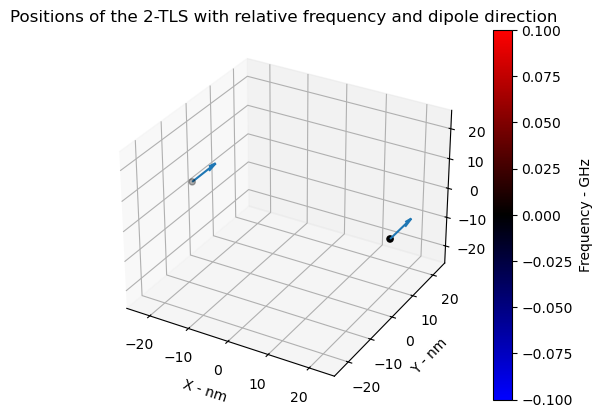

In [212]:
Nx = 2
Ny = 1
N_TLS = Nx*Ny


l0 = 50

theta_NA = np.pi/50


#R = ordered_chain(l0, N_TLS)
R, N_TLS = triang_triangular_lattice( l0, Nx, Ny )


lam0 = 785 # laser wavelength in nm
k0 = 2*np.pi/lam0       # for the dyadic one should in principle use k including the detuning. But 1Ghz of detuning is 10^-7 in k, completely irrelevant
                                    # total volume of the nanocrystal in nm
Lx = 100
Ly = 100
Lz = 100

sx, sy, sz, s_ = spin_operators(N_TLS)

                                    #reference electric field at lambda0 with d = 13 D
Edd_ref = 0.0248 # kV/cm
                                    #include a golden substrate
img_active = 1  #choose to use free space '==0' or half space '==1' dyadic Green function
z0 = - 200     #position in nm of the conductinc plate (only if img_active == 1)

                                    # in GHz - detuning of the molecules with respect external pump, molecules losses, dipole-dipole reference scale
gamma = .05  # homogeneous broadening, or Fourier limit linewidth
gamma_deph = .01 # pure dephasing rate (to be done properly I should include the detuning dependence that takes account of the phonons spectral density)
Udd = 1.    # coefficiente dimensionale dyadic in GHz -> Udd = e^2/epsilon0 k0^3 xi_d^2 ( e xi_d = dipole transition \approx 13 D )
Gamma0 = Udd/(3.*np.pi)     # ==== Single emitter diagonal spontaneous decay rate of the free space dyadic. Necessary to ensure stability.

OmR = 6.
sigma_freqs = 0.
                                    #arr_freq_dis = sigma_freqs*np.random.normal(0.0, 1., size=N_TLS) #array that stores fluctuations of TLS freqs., sigma is in GHz
arr_freq_dis = sigma_freqs*np.random.uniform(-1./2., 1./2., size=N_TLS)

                                    #detuning with respect external laser
det0 = -1.15 #* np.sqrt(N_TLS)        #in Ghz

Gam_p = .0                           #Incoherent pump strength

                                    #select orientation dipoles
direction_dipole = 1    # x==0, y==1, z==2

                                    #define dipole moment axis of each TLS
D = partially_random_dipoles(N_TLS, direction_dipole, 0.0)

plot_points_with_vectors_substrate(R, D, 20., arr_freq_dis, z0)

Edrive = np.array([0, 0, 0])
Edrive[direction_dipole] = 1
projE = np.matmul( D, Edrive )
dir_k = np.array([0, 0, 1])
if direction_dipole == 2 or direction_dipole == 1 :
    dir_k = np.array([1, 0, 0])

K = np.zeros(shape=(N_TLS, N_TLS), dtype=np.complex_)
K = interaction_matrix(R, D, k0, N_TLS, z0, img_active)

Gamma_tens = 2.*Udd*K.imag + (gamma + Gamma0)*np.eye( N_TLS )
ikvals, ikvecs = np.linalg.eig(Gamma_tens)
idx = np.argsort(ikvals)
ikvals = ikvals[idx]
ikvecs = ikvecs[:,idx]

dressed_jump = []
for nik in range(ikvals.size):
    for ntls in range(N_TLS):
        Gk = ikvals[nik]
        if Gk < 0:
            Gk = 0.
        dressed_jump.append( np.sqrt( ( Gk + 1j*0.0 ) ) * ikvecs[ntls,nik] * s_[ntls] )

Heff = 0*sz[0] 
H0 = Heff
arr_cjump = []
Ltot = 0*lindblad_dissipator( s_[0] )
for n1 in range(N_TLS):
    Heff += ( det0 + arr_freq_dis[n1] ) * s_[n1].dag()*s_[n1] + .5*OmR * projE[n1] * (s_[n1]*np.exp(-1j*k0*np.dot(dir_k, R[n1]) ) + s_[n1].dag()*np.exp(+1j*k0*np.dot(dir_k, R[n1]) ) )
    arr_cjump.append( np.sqrt(Gam_p)*s_[n1].dag()  )
    arr_cjump.append( np.sqrt(gamma_deph)*s_[n1].dag()*s_[n1] )
    for n2 in range(N_TLS):
        Heff += - 1.*Udd*K[n1][n2].real * s_[n1].dag()*s_[n2]
        H0 += - 1.*Udd*K[n1][n2].real * s_[n1].dag()*s_[n2]
arr_jump_tot = arr_cjump + dressed_jump
Ltot += liouvillian(Heff, arr_jump_tot)

rho_ss = steadystate(Ltot)
bell_y = 0


In [213]:
print( H0.eigenenergies() )

[-1.15421201 -0.04384874  0.          1.11036327]


In [214]:
rho_ss

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 2.20014596e-01+0.j          7.80264032e-02+0.00858275j
   7.93524224e-02-0.02189431j -9.46313620e-06-0.00210988j]
 [ 7.80264032e-02-0.00858275j  2.47435638e-01+0.j
   3.36351156e-02-0.00120864j  7.97524662e-02-0.02376457j]
 [ 7.93524224e-02+0.02189431j  3.36351156e-02+0.00120864j
   2.49359564e-01+0.j          7.73768524e-02+0.00855758j]
 [-9.46313620e-06+0.00210988j  7.97524662e-02+0.02376457j
   7.73768524e-02-0.00855758j  2.83190202e-01+0.j        ]]

In [281]:
GS = fock(2,1)
GS = tensor(GS, GS)
state = s_[0].dag()*s_[1].dag() * GS #+ GS
rho_ss = state*state.dag()*.9 + GS*GS.dag()
rho_ss = rho_ss.unit()
bell_y = 1
"""if N_TLS == 3:
    state = (s_[0].dag()*s_[1].dag()*s_[2].dag())*ghz_state(3)
    state.unit()
    state = (s_[0] + s_[1] + s_[2])*state
    state.unit()
    rho_ss = state * state.dag()"""
#rho_ss = singlet_state() * singlet_state().dag()

'if N_TLS == 3:\n    state = (s_[0].dag()*s_[1].dag()*s_[2].dag())*ghz_state(3)\n    state.unit()\n    state = (s_[0] + s_[1] + s_[2])*state\n    state.unit()\n    rho_ss = state * state.dag()'

In [282]:
rho_ss

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.47368421 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.52631579]]

In [217]:
dist = lam0*40.
theta = np.linspace( 0., 2.*np.pi, 80)
phi = np.linspace(0, np.pi/2., 80)
polar_Ex, polar_Ey, polar_Ez = polar_matrix_system_dyadic_field_amplitude( R, D, k0, N_TLS, theta, phi, dist, z0, img_active )

@njit
def polar_intensity_matrix(matE, Ni, Nj, Nn, M):
    for i in range(Ni):
        for j in range(Nj):
            for n in range(Nn):
                for m in range(Nn):
                    M[i][j][n][m] = np.conj(matE[i][j][n]) * matE[i][j][m]
    return M
# Get the shape of E
Ni, Nj, Nn = polar_Ex.shape
# Initialize the output tensor M_ijnm
Mxx = np.zeros((Ni, Nj, Nn, Nn), dtype=complex)
Myy = np.zeros((Ni, Nj, Nn, Nn), dtype=complex)
Mzz = np.zeros((Ni, Nj, Nn, Nn), dtype=complex)
Ixx = polar_intensity_matrix(polar_Ex, Ni, Nj, Nn, Mxx)
Iyy = polar_intensity_matrix(polar_Ey, Ni, Nj, Nn, Myy)
Izz = polar_intensity_matrix(polar_Ez, Ni, Nj, Nn, Mzz)

I = Ixx + Iyy + Izz

I[1:theta.size,0,:,:] = I[1:theta.size,0,:,:].copy()*0 #remove the Ntheta-copies of the north-pole
Mprovv = np.zeros((Ni, Nj, Nn, Nn), dtype=complex)

I_avg = solid_angle_averaging(I, Mprovv, theta, phi, theta_NA)

In [283]:
arr_g2_1 = []
arr_g2_2 = []
arr_g2_12 = []

maxI = np.amax(I_avg)

vT1 = phi
vT2 = phi

P1 = 0
P2 = int(theta.size/2)

count = 0
for n_T1, T1 in enumerate(vT1):
    arr_g2_1_p = []
    arr_g2_2_p = []
    arr_g2_12_p = []
    for n_T2, T2 in enumerate(vT2):

        M1_detect = I_avg[ P1 , n_T1 ,:,:]
        m1_vals, m1_vecs = np.linalg.eig(M1_detect)
        idx = np.argsort(m1_vals)
        m1_vals = m1_vals[idx]
        m1_vecs = m1_vecs[:,idx]

        f1_ = []
        for k, ek in enumerate(m1_vals):
            f1_op = s_[0]*0
            for n in range(len(m1_vals)):
                #f1_op += s_[n] * np.conj(m1_vecs[n,k]) * np.sqrt( ek/np.amax(np.abs(m1_vals)) )
                f1_op += s_[n] * np.conj(m1_vecs[n,k]) * np.sqrt( ek/maxI )
            f1_.append(f1_op)
            
        M2_detect = I_avg[ P2 , n_T2 ,:,:]
        m2_vals, m2_vecs = np.linalg.eig(M2_detect)
        idx = np.argsort(m2_vals)
        m2_vals = m2_vals[idx]
        m2_vecs = m2_vecs[:,idx]

        f2_ = []
        for k, ek in enumerate(m2_vals):
            f2_op = s_[0]*0
            for n in range(len(m2_vals)):
                #f2_op += s_[n] * np.conj(m2_vecs[n,k]) * np.sqrt( ek/np.amax(np.abs(m2_vals)) )
                f2_op += s_[n] * np.conj(m2_vecs[n,k]) * np.sqrt( ek/maxI )
            f2_.append(f2_op)
        
        

        C1 = 0
        N1 = 0

        C2 = 0
        N2 = 0

        C12 = 0

        for k1 in range(len(m1_vals)):
            N1 += expect( f1_[k1].dag()*f1_[k1], rho_ss)
            N2 += expect( f2_[k1].dag()*f2_[k1], rho_ss)
            for k2 in range(len(m1_vals)):
                
                C1 += expect( f1_[k1].dag()*f1_[k2].dag()*f1_[k2]*f1_[k1], rho_ss )
                C2 += expect( f2_[k1].dag()*f2_[k2].dag()*f2_[k2]*f2_[k1], rho_ss )
                C12 += expect( f1_[k1].dag()*f2_[k2].dag()*f2_[k2]*f1_[k1], rho_ss )
                
        chi = 0
        chi_p = 0

        g2_1 = C1 / N1**2
        g2_2 = C2 / N2**2
        g2_12 = C12 / (N1*N2)

        arr_g2_1_p.append(g2_1)
        arr_g2_2_p.append(g2_2)
        arr_g2_12_p.append(g2_12)

        sys.stdout.write("Completed = %.1f %% \r" % (100*count/(len(vT1)*len(vT1)) ))
        sys.stdout.flush()
        count += 1
    
    arr_g2_1.append(arr_g2_1_p)
    arr_g2_2.append(arr_g2_2_p)
    arr_g2_12.append(arr_g2_12_p)


arr_g2_1 = np.asarray(arr_g2_1)
arr_g2_2 = np.asarray(arr_g2_2)
arr_g2_12 = np.asarray(arr_g2_12)


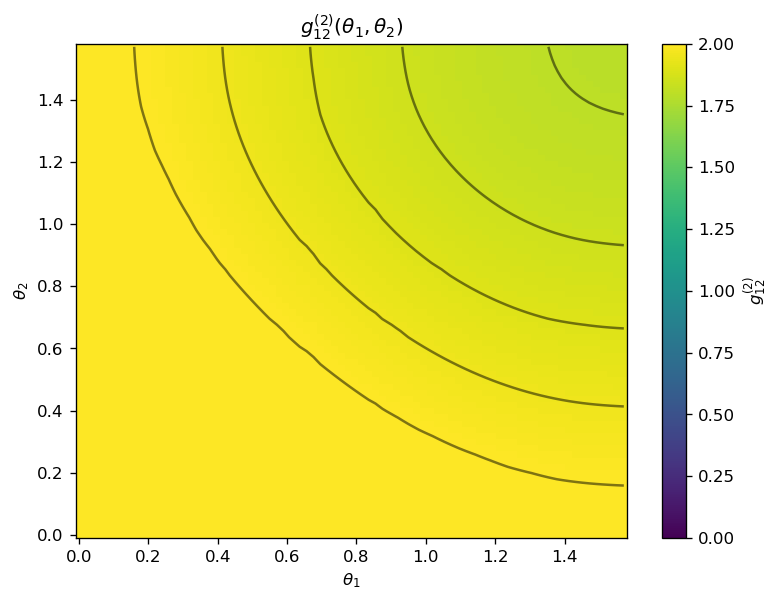

In [284]:
# Assume:
# vT1, vT2 are 1D arrays of angles (e.g. in rad)
# arr_g2_12 has shape (len(vT2), len(vT1))  # check this!

Theta1, Theta2 = np.meshgrid(vT1, vT2)

fig, ax = plt.subplots(1, 1, dpi=120, figsize=(4, 3))

# Normalise if you want g2/g2_max, otherwise just use arr_g2_12
if bell_y == 1:
    g2_norm = arr_g2_12.real
else:
    g2_norm = arr_g2_12.real

# Choose color scale limits (adjust to your data)
vmin = 0.0
vmax = 2.

# Main colormap
Emap_plot = ax.pcolormesh(Theta1, Theta2, g2_norm,
                          cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')

# Contours
contour_min = vmin
contour_max = vmax
contour_interval = 0.05
levels = np.arange(contour_min, contour_max + contour_interval, contour_interval)

contours = ax.contour(Theta1, Theta2, g2_norm,
                      levels=levels, colors='black', alpha=0.5)

# Axis labels (θ in radians; change to degrees if you prefer)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'$g^{(2)}_{12}(\theta_1, \theta_2)$')

# Colorbar
cbar = fig.colorbar(Emap_plot, ax=ax)
cbar.set_label(r'$g^{(2)}_{12}$')

plt.gcf().set_size_inches(170 / 25.4, 130 / 25.4)  # match your size style
plt.tight_layout()
# plt.savefig('g2_12_thetas.png', dpi=300)
plt.show()